# Homework 2

## Getting the data

In [194]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv --output ./housing.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1390k  100 1390k    0     0  3211k      0 --:--:-- --:--:-- --:--:-- 3217k


## EDA

In [195]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

Loading Data

In [196]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Looking at distribution of pricing

<Axes: >

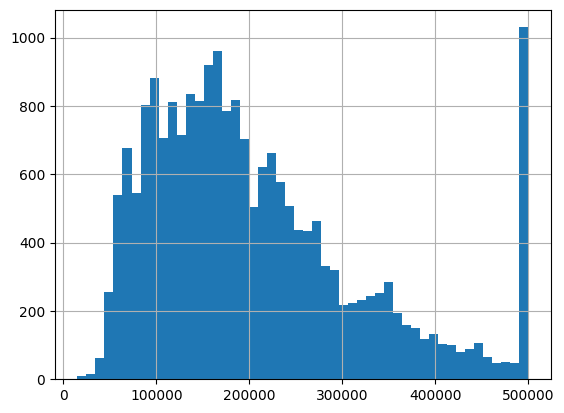

In [197]:
df['median_house_value'].hist(bins=50)

It does not have a very long tail but a lot of outliers

### Data preparation

Selecting ocean proximity

In [198]:
## Homework
df = df[(df['ocean_proximity'] == "<1H OCEAN") | (df['ocean_proximity'] == "INLAND")]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


Selecting a subset of columns

In [199]:
df = df[['latitude',
'longitude',
'housing_median_age',
'total_rooms',
'total_bedrooms',
'population',
'households',
'median_income',
'median_house_value']]

df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


> There's one feature with missing values. What is it?

In [200]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

> What's the median (50% percentile) for variable 'population'?

In [201]:
df['population'].median()

1195.0

Shuffling the dataset

In [202]:
df = df.sample(frac=1, random_state=42)
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
19963,36.23,-119.14,22.0,2935.0,523.0,1927.0,530.0,2.5875,70400.0
5929,34.12,-117.79,16.0,2426.0,426.0,1319.0,446.0,4.8125,224500.0
11377,33.68,-117.97,26.0,3653.0,568.0,1930.0,585.0,5.7301,260900.0
6443,34.10,-118.03,32.0,2668.0,609.0,1512.0,541.0,2.9422,233100.0
17546,37.34,-121.87,39.0,2479.0,541.0,1990.0,506.0,2.4306,289100.0


Splitting the dataset

In [203]:
train, test = train_test_split(df, train_size=0.6)
val, test = train_test_split(test, train_size=0.5)

In [204]:
def apply_log1p(data):
    data['median_house_value'] = np.log1p(data['median_house_value'])
    return data


train = apply_log1p(train)
val = apply_log1p(val)
test = apply_log1p(test)

In [205]:
def train_regression(train,val):
    model = LinearRegression()
    X_train, y_train = train.drop(columns=['median_house_value']), train[['median_house_value']]
    X_val, y_val = val.drop(columns=['median_house_value']), val[['median_house_value']]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    score = mean_squared_error(y_val, y_pred, squared=False)
    return score

def apply_fill(data, val):
    new_data = data.copy()
    new_data['total_bedrooms'] = new_data['total_bedrooms'].fillna(val)
    return new_data

mean_val = train['total_bedrooms'].mean()

train_mean = apply_fill(train, mean_val)
val_mean = apply_fill(val, mean_val)
test_mean = apply_fill(test, mean_val)

train_zero = apply_fill(train, 0)
val_zero = apply_fill(val, 0)
test_zero = apply_fill(test, 0)

print(f'RMSE score on mean: {train_regression(train_mean, val_mean)}')
print(f'RMSE score on zero: {train_regression(train_zero, val_zero)}')

RMSE score on mean: 0.33980420915128917
RMSE score on zero: 0.3393798039161215


Training regression with regularization

In [206]:
def train_regularized_regression(train, val, r):
    model = Ridge(r, random_state=42)
    X_train, y_train = train.drop(columns=['median_house_value']), train[['median_house_value']]
    X_val, y_val = val.drop(columns=['median_house_value']), val[['median_house_value']]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    score = mean_squared_error(y_val, y_pred, squared=False)
    return score

r_vals = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

scores = dict()
for r in r_vals:
    scores[r] = train_regularized_regression(train_zero, val_zero, r)

best_score = min(scores, key=lambda x: scores[x])
scores

{0: 0.33937980391612144,
 1e-06: 0.33937980391377387,
 0.0001: 0.339379803681351,
 0.001: 0.33937980156842706,
 0.01: 0.3393797804401275,
 0.1: 0.3393795692511976,
 1: 0.33937746676056807,
 5: 0.33936832824175817,
 10: 0.33935737386885617}

In [207]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def train_random_regression(seed):
    train, test = train_test_split(df, train_size=0.6, random_state=seed)
    val, test = train_test_split(test, train_size=0.5, random_state=seed)
    
    train = apply_log1p(train)
    val = apply_log1p(val)

    train_zero = apply_fill(train, 0)
    val_zero = apply_fill(val, 0)
    
    model = LinearRegression()

    X_train, y_train = train_zero.drop(columns=['median_house_value']), train_zero[['median_house_value']]
    X_val, y_val = val_zero.drop(columns=['median_house_value']), val_zero[['median_house_value']]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    score = mean_squared_error(y_val, y_pred, squared=False)
    return score

scores = []
for seed in seed_values:
    scores.append(train_random_regression(seed))
np.std(scores)
# scores

0.005589859005004672

In [208]:
train, test = train_test_split(df, train_size=0.6, random_state=9)
val, test = train_test_split(test, train_size=0.5, random_state=9)

train = pd.concat([train, val], ignore_index=True)

train = apply_log1p(train)
test = apply_log1p(test)

train_zero = apply_fill(train, 0)
test_zero = apply_fill(test, 0)

X_train, y_train = train_zero.drop(columns=['median_house_value']), train_zero[['median_house_value']]
X_test, y_test = test_zero.drop(columns=['median_house_value']), test_zero[['median_house_value']]


model = Ridge(0.001)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_pred, y_test, squared=False)

0.3432873502789519